In [1]:
import pandas as pd
import os, json
import random
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
from PIL import Image
import zipfile
import cv2
import glob
from skimage.io import imread
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
from sklearn.model_selection import train_test_split
import h5py

Using TensorFlow backend.


# AUTOENCODER

In [2]:
train_dir= 'imgs27638.h5'
images = h5py.File(train_dir,'r')
a_group_key = list(images.keys())[0]

In [3]:
data = list(images[a_group_key])

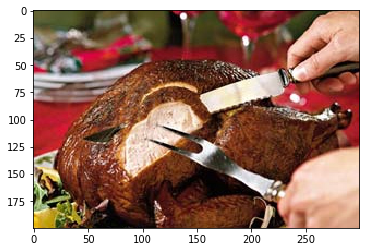

In [4]:
plt.imshow(data[5])

In [5]:
labels = pd.read_csv('flavours.csv',nrows=len(data))
labels = np.array(labels)
nan_labels = np.isnan(labels).any(axis=1)
print(nan_labels)

[ True False False ... False False  True]


In [6]:
#Remove nan rows from labels and images
new_labels = np.delete(labels,np.where(nan_labels==True),axis=0)

new_images= norm(np.delete(data,np.where(nan_labels==True),axis=0)

In [165]:
#Transform the labels
from sklearn.preprocessing import OneHotEncoder,normalize
labels = pd.DataFrame(new_labels)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(labels)
labels = enc.transform(labels).toarray()

In [88]:
print(new_images.shape)
print(labels.shape)

(2839, 200, 300, 3)
(2839, 41)


In [168]:
#Reshape images
reshaped_imgs = []
for img in new_images:
    reshaped_imgs.append(cv2.resize(img,(128,128)))
reshaped_imgs = np.array(reshaped_imgs)

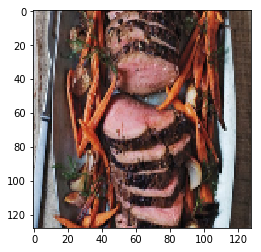

In [141]:
plt.imshow(reshaped_imgs[5])

In [144]:
reshaped_imgs.shape

(2839, 128, 128, 3)

# Autoencoder

In [233]:
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(128, 128, 3))
model = Sequential()

#Encoder

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3), padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

#Decoder

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['accuracy'])

# Classification

In [234]:
# from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
# from keras.models import Model, Sequential
# from keras.optimizers import SGD

# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=(128,128,3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(6, activation='sigmoid'))

# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [235]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_201 (Conv2D)          (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_202 (Conv2D)          (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 32, 32, 128)       147584    
_________________________________________________________________
up_sampling2d_64 (UpSampling (None, 64, 64, 128)       0         
__________

In [236]:
#Make train/test sets for classification
#X_train, X_test, y_train, y_test = train_test_split(np.array(reshaped_imgs), new_labels,test_size=0.2)

#Make train/test sets for autoencoder
X_train, X_test, y_train, y_test = train_test_split(np.array(reshaped_imgs), new_labels,test_size=0.2)


In [237]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

#Compute quantities for featurewise normalization
datagen.fit(X_train)

#Fit model 
model.fit_generator(datagen.flow(X_train, X_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=10)

Epoch 1/10
71/70 [==============================] - 252s 4s/step - loss: 23365.9229 - acc: 0.7466
Epoch 2/10
71/70 [==============================] - 247s 3s/step - loss: 23363.9966 - acc: 0.7667
Epoch 3/10
71/70 [==============================] - 246s 3s/step - loss: 23363.3147 - acc: 0.7668
Epoch 4/10
71/70 [==============================] - 245s 3s/step - loss: 23363.1184 - acc: 0.7668
Epoch 5/10
71/70 [==============================] - 243s 3s/step - loss: 23363.8220 - acc: 0.7668
Epoch 6/10
71/70 [==============================] - 242s 3s/step - loss: 23364.6626 - acc: 0.7668
Epoch 7/10
71/70 [==============================] - 240s 3s/step - loss: 23364.0816 - acc: 0.7668
Epoch 8/10
71/70 [==============================] - 240s 3s/step - loss: 23364.0011 - acc: 0.7668
Epoch 9/10
71/70 [==============================] - 240s 3s/step - loss: 23363.8095 - acc: 0.7668
Epoch 10/10
71/70 [==============================] - 240s 3s/step - loss: 23363.5870 - acc: 0.7668


In [242]:
pred = model.predict(X_test)

Test Images


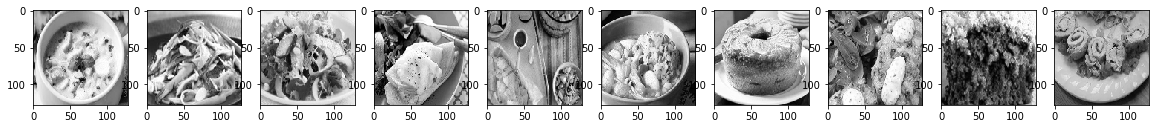

Reconstruction of Test Images


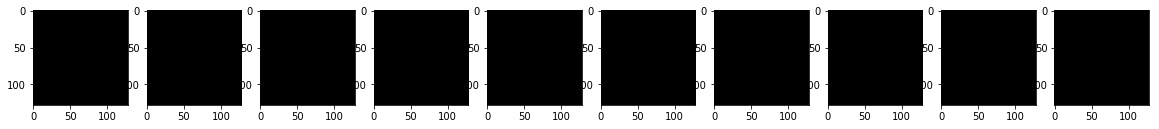

In [243]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[i, ..., 0], cmap='gray')
    curr_lbl = y_test[i]
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()